In [1]:
import numpy as np
import pandas as pd
import seaborn; seaborn.set()
from pmdarima import auto_arima
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib.pylab as plt

In [2]:
btcNov_df = pd.read_csv('../../Resources/BTC/BTC-USD_Historical_Nov-2021.csv',index_col='Date', parse_dates= True)
btcNov_df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1191.099976,755.755981,970.403015,970.403015,5.143972e+09
2017-02-01,970.940979,1200.390015,946.690979,1179.969971,1179.969971,4.282761e+09
2017-03-01,1180.040039,1280.310059,903.713013,1071.790039,1071.790039,1.087246e+10
2017-04-01,1071.709961,1347.910034,1061.089966,1347.890015,1347.890015,9.757448e+09
2017-05-01,1348.300049,2763.709961,1348.300049,2286.409912,2286.409912,3.426186e+10


In [3]:
btcNov_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [4]:
btcNov_df = btcNov_df.drop(columns=['Open','High','Low','Adj Close','Volume'])

In [5]:
btcNov_df.head(10)

,Close
Date,
2017-01-01,970.403015
2017-02-01,1179.969971
2017-03-01,1071.790039
2017-04-01,1347.890015
2017-05-01,2286.409912
2017-06-01,2480.840088
2017-07-01,2875.340088
2017-08-01,4703.390137
2017-09-01,4338.709961


In [6]:
btcNov_df.dtypes

Close    float64
dtype: object

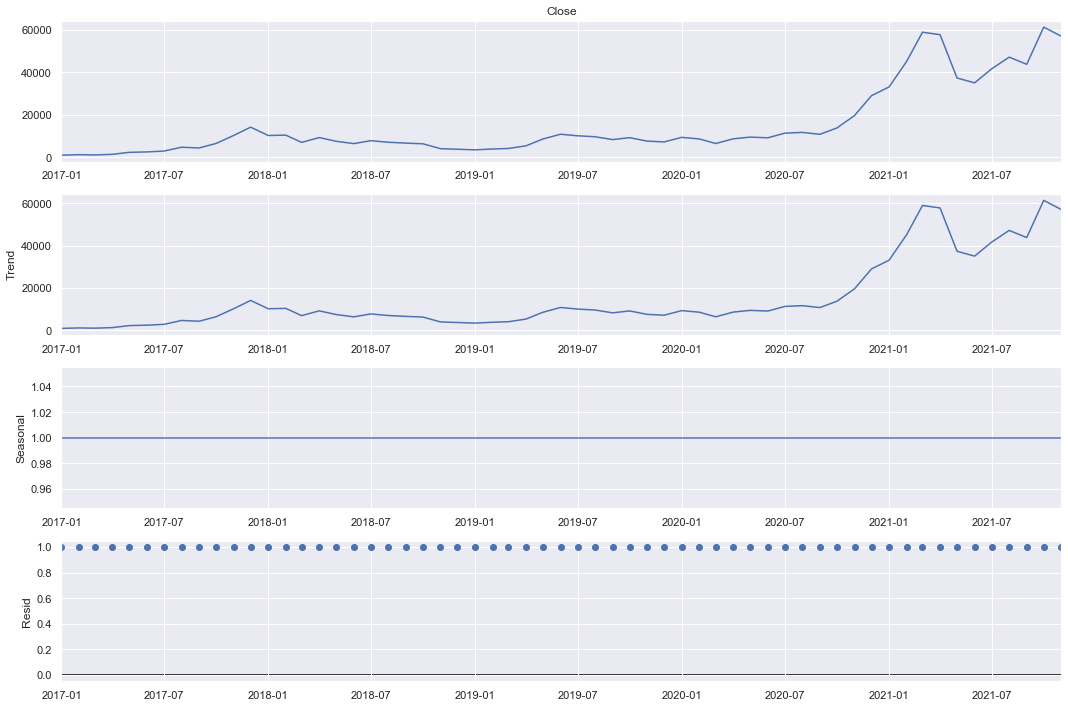

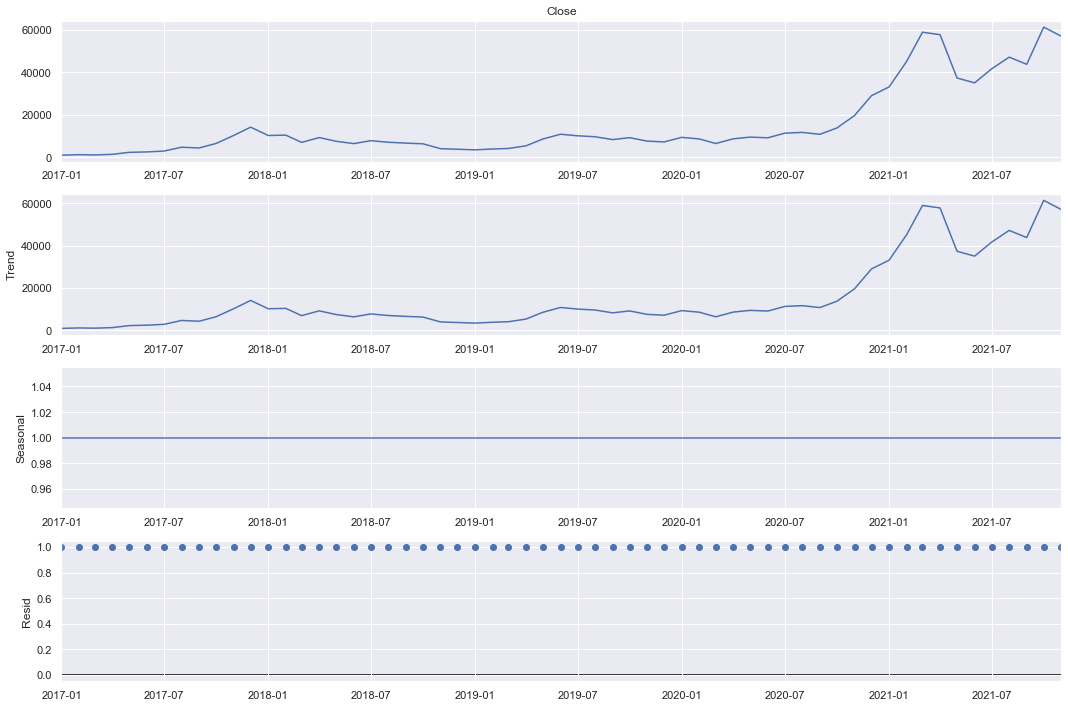

In [7]:
results = seasonal_decompose(btcNov_df['Close'],model ='multiplicative',period=1)
plt.rcParams.update({'figure.figsize': (15,10)})
results.plot()

In [8]:
#Arima
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function to BTC dataset
stepwise_fit = auto_arima(btcNov_df['Close'], start_p = 0, start_q = 0,
max_p = 4, max_q = 4, m = 12,
start_P = 0, seasonal = True,
d = None, D = 1, trace = True,
error_action ='ignore', # we don't want to know if an order does not work
suppress_warnings = True, # we don't want convergence warnings
stepwise = True)# set to stepwise

# To print the summary
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=930.304, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=931.599, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=931.615, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=930.804, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=935.711, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=932.048, Time=0.07 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=931.405, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=934.024, Time=0.15 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=931.035, Time=0.05 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=932.654, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=931.439, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 2.449 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   59
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -463.152
Date:                              Sun, 12 Dec 2021   AIC                            930.304
Time:                                      16:15:31   BIC                            933.962
Sample:                                           0   HQIC                           931.674
                                               - 59                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.5515      0.507     -1.088      0.276      -1.544       0.442
sigma2      3.183e+07   3.92e+06      8.117      0.000    2.41e+07    3.95e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.40   Jarque-Bera (JB):                50.70
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):              23.27   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# Split data into train / test sets
train = btcNov_df.iloc[:len(btcNov_df)-12]
test = btcNov_df.iloc[len(btcNov_df)-12:] # set one year(12 months) for testing

# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Close'],
order = (0, 1, 1),
seasonal_order =(2, 1, 1, 12))

result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                   47
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -301.009
Date:                            Sun, 12 Dec 2021   AIC                            612.018
Time:                                    16:15:31   BIC                            619.649
Sample:                                01-01-2017   HQIC                           614.620
                                     - 11-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1304      0.250      0.522      0.602      -0.359       0.620
ar.S.L12      -0.9857      0.293     -3.366      0.001      -1.560      -0.412
ar.S.L24      -0.8517      0.225     -3.784      0.000      -1.293      -0.411
ma.S.L12      -0.2060      0.785     -0.263      0.793      -1.744       1.332
sigma2      1.571e+06   9.25e+05      1.698      0.089   -2.42e+05    3.38e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.81   Prob(JB):                         0.39
Heteroskedasticity (H):               2.06   Skew:                             0.41
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

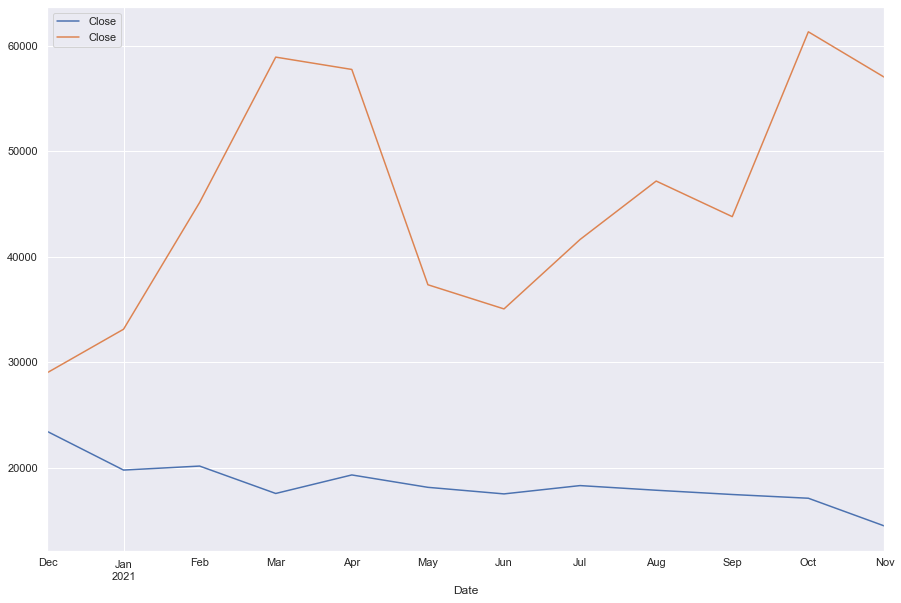

In [10]:
#Predictions of ARIMA Model agains the Test set
start = len(train)
end = len(train) + len(test) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end,typ = 'levels').rename("Close")

# plot predictions and actual values
predictions.plot(legend = True)
test['Close'].plot(legend = True)


In [11]:
#Evaluate the model using MSE and RMSE
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
rmse(test["Close"], predictions)

29675.650231018528

In [12]:
# Calculate mean squared error
mean_squared_error(test["Close"], predictions)

880644216.6337501

Text(0, 0.5, 'Closing Amount (USD)')

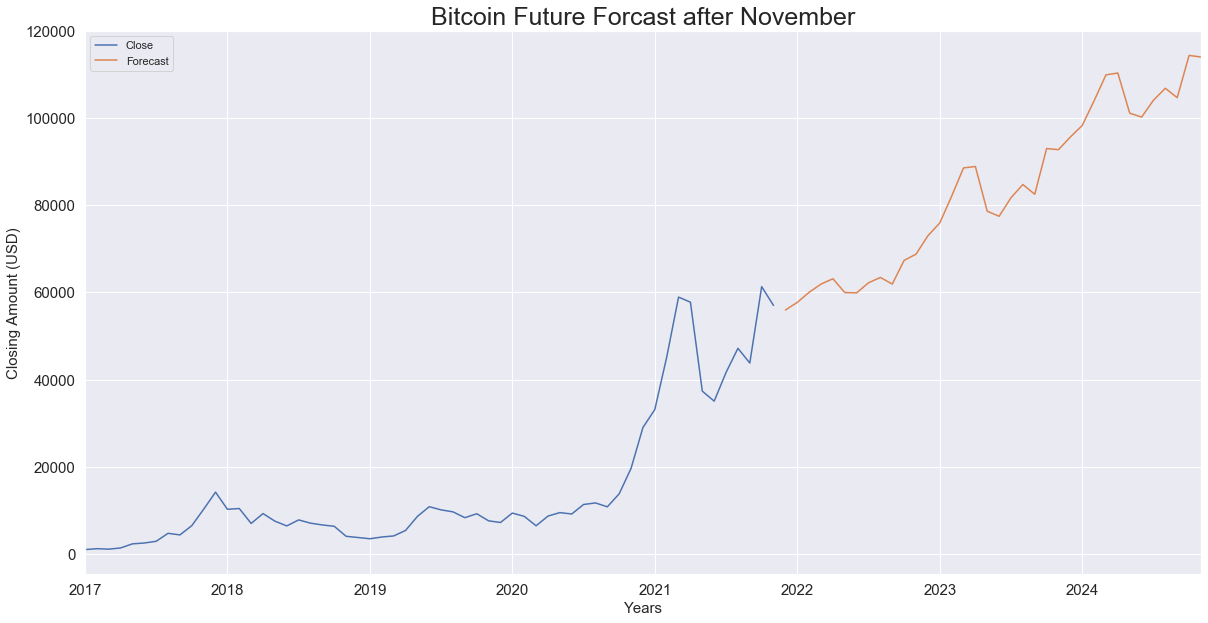

In [13]:
# Train the model on the full dataset
model = model = SARIMAX(btcNov_df['Close'],order = (0, 1, 1),seasonal_order =(2, 1, 1, 12))
result = model.fit()

# Forecast for the next 3 years
forecast = result.predict(start = len(btcNov_df),end = (len(btcNov_df)-1) + 3 * 12,typ = 'levels').rename('Forecast')

# Plot the forecast values
btcNov_df['Close'].plot(figsize = (20, 10), legend = True, fontsize =15)
forecast.plot(legend = True)
plt.title("Bitcoin Future Forcast after November", fontsize = 25)
plt.xlabel('Years',fontsize=15)
plt.ylabel('Closing Amount (USD)',fontsize=15)
